# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [1]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
#%pip install umap
#%pip install umap-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

import pickle

c:\Users\c678456\AppData\Local\anaconda3\envs\dmeyf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
base_path = 'C:/Users/c678456/Desktop/Ian/Maestría/Especializacion/2do_cuatrimestre/DMEyF/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_fe.csv'

In [4]:
# Datos.
df_train = pd.read_csv(dataset_path + dataset_file)

In [5]:
# Modelo.
filename = modelos_path + 'exp_206_rf_100_imputacion_media.sav'
model_rf = pickle.load(open(filename, 'rb'))

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [6]:
# Filtro los cuatro meses de entrenamiento.
mes_train = [202101,202102,202103,202104]
df_train = df_train[df_train['foto_mes'].isin(mes_train)]

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [7]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [8]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [9]:
#imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
#Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

#model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, random_state=17 )
#model.fit(Xtrain_rf_imp, ytrain_rf)

model_rf.fit(Xtrain_rf,ytrain_rf)

RandomForestClassifier(max_depth=23, max_features=0.40060455200913236,
                       max_samples=0.7, min_samples_leaf=47,
                       min_samples_split=52, n_jobs=-1, oob_score=True,
                       random_state=211777)

Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [10]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

#md = distanceMatrix(model, Xtrain_rf_imp)
md = distanceMatrix(model_rf, Xtrain_rf)

Veamos como se ve. Recuerde que significa que un número esté cerca de 0 o que esté cerca de 1.

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

c:\Users\c678456\AppData\Local\anaconda3\envs\dmeyf\Lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\c678456\AppData\Local\anaconda3\envs\dmeyf\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


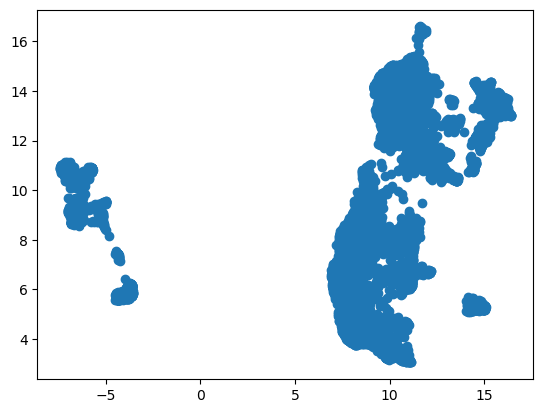

In [11]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
  random_state=17,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

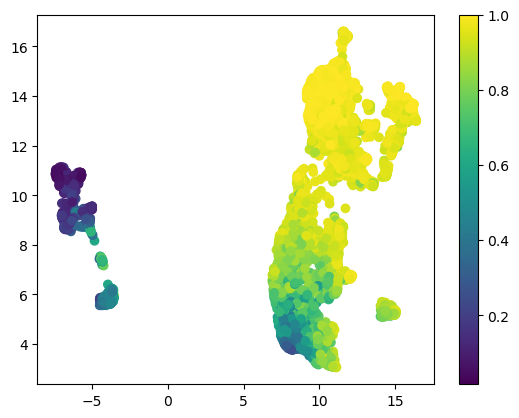

In [12]:
#class_index = np.where(model.classes_ == 1)[0]
#prob_baja = model.predict_proba(Xtrain_rf_imp)[:,class_index]

class_index = np.where(model_rf.classes_ == 1)[0]
prob_baja = model_rf.predict_proba(Xtrain_rf)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

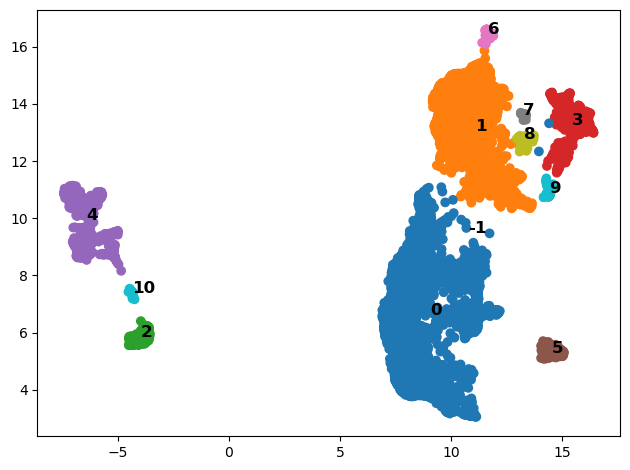

In [13]:
hdb = DBSCAN(eps=0.3)
y = hdb.fit(embedding_rf)

# Agregar etiquetas de clúster
unique_labels = set(y.labels_)
for label in unique_labels:
    # Filtrar los puntos de cada clúster
    cluster_points = embedding_rf[y.labels_ == label]
    
    # Calcular el centroide del clúster para colocar la etiqueta
    centroid = cluster_points.mean(axis=0)
    
    # Colocar el número del clúster en el gráfico
    plt.text(centroid[0], centroid[1], str(label), fontsize=12, fontweight='bold', color='black')
    
plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')
plt.tight_layout()
plt.show()

In [14]:
# Aplana el array de prob_baja para que sea unidimensional
prob_baja_flat = prob_baja.ravel()  # O usa prob_baja.flatten() si prefieres

# Verifica que ahora ambos arrays sean unidimensionales y tengan la misma longitud
print(f"Dimensiones de etiquetas de clusters: {y.labels_.shape}")
print(f"Dimensiones de probabilidad de baja (aplanado): {prob_baja_flat.shape}")

# Crear el DataFrame si las dimensiones coinciden
if y.labels_.shape[0] == prob_baja_flat.shape[0]:
    df_clusters = pd.DataFrame({
        'cluster': y.labels_,  # Etiquetas de los clusters del DBSCAN
        'prob_baja': prob_baja_flat  # Probabilidades de baja de cada cliente (aplanado)
    })

    # Paso 2: Calcular el promedio de probabilidad de baja por cluster
    cluster_avg_prob_baja = df_clusters.groupby('cluster')['prob_baja'].mean()

    # Mostrar los resultados
    print(cluster_avg_prob_baja)
else:
    print("Las dimensiones de 'y.labels_' y 'prob_baja' aún no coinciden.")

Dimensiones de etiquetas de clusters: (9394,)
Dimensiones de probabilidad de baja (aplanado): (9394,)
cluster
-1     0.906081
 0     0.786585
 1     0.981659
 2     0.436311
 3     0.978593
 4     0.143044
 5     0.853713
 6     0.972908
 7     0.946249
 8     0.980681
 9     0.936963
 10    0.657794
Name: prob_baja, dtype: float64


Veamos cuantos cluster detecto y cuantos clientes tiene cada uno

Los que tienen -1, son considerados outliers.

Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

In [15]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=17)
  #model.fit(Xtrain_rf_imp, y_binary)
  model.fit(Xtrain_rf, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

Y exploramos cuales son las variables importantes por cada cluster

In [82]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:15]:
    print(f"  - {feature}")

Cluster 0 vs. Resto:
  - m_payroll_total
  - mpayroll
  - mpasivos_margen
  - cpayroll_trx
  - m_payroll2_total
  - m_promedio_caja_ahorro
  - mcaja_ahorro
  - Visa_msaldopesos
  - tc_pagadopesos_total
  - Visa_mpagominimo
  - tc_saldopesos_total
  - Visa_msaldototal
  - mpayroll_slope_3
  - proporcion_financiacion_total_cubierto
  - mcuentas_saldo
Cluster 1 vs. Resto:
  - mpasivos_margen
  - mcaja_ahorro
  - ctrx_quarter
  - m_promedio_caja_ahorro
  - mcaja_ahorro_slope_3
  - Visa_msaldopesos
  - proporcion_limite_visa_cubierto
  - tc_saldopesos_total
  - Visa_msaldototal
  - tc_pagadopesos_total
  - tc_consumo_total_slope_3
  - mprestamos_personales
  - mactivos_margen_slope_3
  - proporcion_financiacion_total_cubierto
  - mtarjeta_visa_consumo
Cluster 2 vs. Resto:
  - mpayroll
  - m_payroll_total
  - cpayroll_trx
  - m_payroll2_total
  - mtarjeta_visa_consumo
  - m_promedio_tarjeta_visa_consumo
  - Visa_msaldototal
  - Visa_msaldopesos
  - tc_consumo_total
  - ccomisiones_mantenimie

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda


#### 1. Creo el dataframe a analizar.

In [17]:
df_analizar = Xtrain_rf.copy()
df_analizar['cluster'] = y.labels_

#### 2. Análisis de cada clúster.

In [119]:
descriptivo_cluster = {}
for cluster, features in important_features_by_cluster.items():
    #print("\n\nCLUSTER {}\n\n".format(cluster))
    features_filtrar = features[:15]+["cliente_edad","cliente_antiguedad"]
    df = df_analizar[df_analizar["cluster"] == cluster][features_filtrar]
    descriptivo_cluster[cluster] = df.describe()

##### a. Clúster 0 (vs clúster 4).

In [120]:
descriptivo_cluster[0]

,m_payroll_total,mpayroll,mpasivos_margen,cpayroll_trx,m_payroll2_total,m_promedio_caja_ahorro,mcaja_ahorro,Visa_msaldopesos,tc_pagadopesos_total,Visa_mpagominimo,tc_saldopesos_total,Visa_msaldototal,mpayroll_slope_3,proporcion_financiacion_total_cubierto,mcuentas_saldo,cliente_edad,cliente_antiguedad
count,3973.000000,3973.000000,3973.000000,3973.000000,3973.000000,3.973000e+03,3.973000e+03,3.786000e+03,3.973000e+03,3.786000e+03,3.973000e+03,3.786000e+03,3243.000000,3798.000000,3.973000e+03,3973.000000,3973.000000
mean,87.282890,87.282890,864.604037,0.033728,0.033728,1.685431e+04,3.632837e+04,3.183735e+04,-2.886439e+04,6.676713e+03,3.755730e+04,2.801418e+04,-1796.529071,0.113916,9.708012e+04,50.293733,129.687390
std,814.461384,814.461384,2268.901473,0.276414,0.276414,5.773132e+04,1.239589e+05,7.462051e+04,5.497276e+04,3.364469e+04,1.151595e+05,6.836119e+04,21603.706343,0.578426,6.455334e+05,14.302658,86.863484
min,0.000000,0.000000,-11344.740000,0.000000,0.000000,-1.153725e+02,-4.614900e+02,-3.606471e+05,-1.609767e+06,0.000000e+00,-3.488568e+05,-9.605789e+04,-395081.630000,-0.570352,-3.080092e+05,22.000000,1.000000
25%,0.000000,0.000000,107.350000,0.000000,0.000000,1.766000e+02,3.686000e+02,3.956840e+03,-3.507013e+04,1.876800e+02,3.379650e+03,3.368642e+03,0.000000,0.008653,-1.535330e+03,39.000000,57.000000
50%,0.000000,0.000000,307.100000,0.000000,0.000000,2.989120e+03,6.340730e+03,1.399904e+04,-1.346953e+04,1.337220e+03,1.469252e+04,1.193368e+04,0.000000,0.038771,3.772080e+03,49.000000,118.000000
75%,0.000000,0.000000,797.360000,0.000000,0.000000,1.160457e+04,2.558328e+04,3.664623e+04,-2.352050e+03,4.372358e+03,4.048302e+04,3.131157e+04,0.000000,0.110864,4.087131e+04,62.000000,182.000000
max,11480.940000,11480.940000,55303.150000,7.000000,7.000000,1.806703e+06,3.613406e+06,2.138793e+06,5.112715e+04,1.221105e+06,3.611552e+06,1.823353e+06,855861.505000,24.287876,2.334740e+07,92.000000,376.000000


In [21]:
descriptivo_cluster[4]

,cpayroll_trx,mpayroll,m_payroll2_total,m_payroll_total,mpayroll_slope_3,ctrx_quarter,tc_consumo_total,mtarjeta_visa_consumo,m_promedio_tarjeta_visa_consumo,cextraccion_autoservicio
count,994.000000,9.940000e+02,994.000000,9.940000e+02,7.470000e+02,994.000000,994.000000,994.000000,994.000000,994.000000
mean,1.769618,1.505240e+05,1.771630,1.506017e+05,1.043974e+04,138.158954,41721.644809,35422.492897,2737.811959,3.551308
std,1.495291,2.845154e+05,1.494926,2.844989e+05,2.285758e+05,67.813714,47180.578450,39631.677049,3390.416629,4.248083
min,0.000000,9.849420e+03,0.000000,1.155302e+04,-5.353672e+06,15.000000,2008.970000,1555.030000,489.281667,0.000000
25%,1.000000,6.618193e+04,1.000000,6.618193e+04,-5.730095e+03,90.000000,14112.875000,12219.335000,1464.011673,0.000000
50%,1.000000,1.040908e+05,1.000000,1.044711e+05,3.572960e+03,130.000000,26784.050000,22971.030000,2058.807879,2.000000
75%,2.000000,1.570596e+05,2.000000,1.570596e+05,1.885731e+04,169.750000,50912.152500,42146.112500,2875.962717,5.000000
max,18.000000,6.517532e+06,18.000000,6.517532e+06,1.869537e+06,407.000000,441520.570000,389638.990000,56607.800000,32.000000


In [22]:
# Si comparamos el clúster 0 con el 4 (CONTINUA CLARAMENTE), vemos que...
# - Son claramente Trabajadores con aumentos de sueldo.
# - Hacen transacciones bancarias.
# - Usan la tarjeta de crédito de gran manera.
# - Hacen extracciones del autoservicio, etc.

In [ ]:
# Análisis vs el Resto.

In [70]:
#1. Payroll ----> No reciben un sueldo (no apego con el banco).
# Gráfico.
cluster_0 = df_analizar.copy()
cluster_0["cluster"] = df_analizar['cluster'].apply(lambda x: '0' if x == 0 else 'Resto')

df_analizar.groupby("cluster")[["mpayroll","cpayroll_trx"]].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()

cluster       mpayroll                                                   \
                     mean            std       min         max      median   
0       -1       0.000000       0.000000      0.00        0.00       0.000   
1        0      87.282890     814.461384      0.00    11480.94       0.000   
2        1      14.728707     255.740944      0.00     6721.72       0.000   
3        2  100069.687796  124419.525320  11730.00  1524900.00   73942.800   
4        3       7.904313     215.310924      0.00     5865.00       0.000   
5        4  150523.955704  284515.443363   9849.42  6517531.68  104090.845   
6        5     115.895316    1039.770982      0.00    10458.69       0.000   
7        6      55.616379     599.006737      0.00     6451.50       0.000   
8        7    5808.040741    3632.154899      3.42    11730.00    5865.000   
9        8       0.000000       0.000000      0.00        0.00       0.000   
10       9     244.258246    1400.460381      0.00     9817.22       0.000   
11      10   83774.775370  105565.580488  11964.60   663336.19   51546.835   

   cpayroll_trx                           
           mean       std min max median  
0      0.000000  0.000000   0   0    0.0  
1      0.033728  0.276414   0   7    0.0  
2      0.008671  0.136813   0   5    0.0  
3      1.740132  1.315646   1  13    1.0  
4      0.001348  0.036711   0   1    0.0  
5      1.769618  1.495291   0  18    1.0  
6      0.016878  0.158549   0   2    0.0  
7      0.008621  0.092848   0   1    0.0  
8      1.592593  0.693889   1   4    2.0  
9      0.000000  0.000000   0   0    0.0  
10     0.052632  0.294051   0   2    0.0  
11     1.870370  1.010255   1   5    2.0

In [69]:
#2. mpasivos_margen ----> Provoca un margen por pasivos mucho mayor (el banco trabaja esa plata), excepto por el cluster 4.
cluster_0 = df_analizar.copy()
cluster_0["cluster"] = df_analizar['cluster'].apply(lambda x: '0' if x == 0 else 'Resto')

df_analizar.groupby("cluster")["mpasivos_margen"].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()

,cluster,mean,std,min,max,median
0,-1,318.907143,515.982476,0.00,1711.88,62.750
1,0,864.604037,2268.901473,-11344.74,55303.15,307.100
2,1,10.617937,123.994379,-4938.72,401.12,2.165
3,2,1272.123487,4520.526498,-3546.38,67694.21,283.020
4,3,17.569879,67.333964,-921.95,439.92,1.780
5,4,1543.256076,2829.097779,-3091.88,39058.46,778.030
6,5,65.158143,133.612839,-165.08,1467.01,19.140
7,6,98.783017,105.902604,-265.39,360.54,66.650
8,7,16.693704,39.755214,0.00,203.34,2.630
9,8,-2.188333,115.675766,-846.75,337.96,0.000


<Axes: xlabel='cluster', ylabel='mpasivos_margen'>

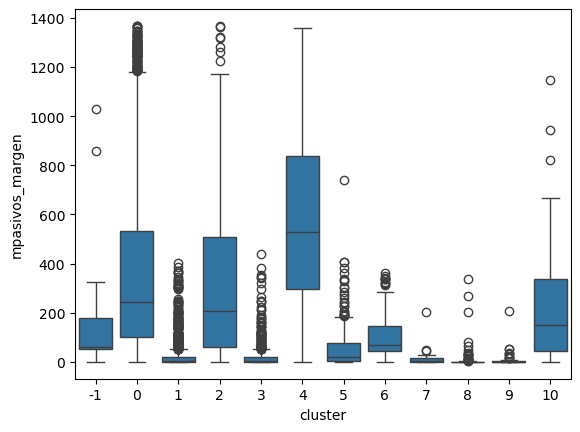

In [68]:
lower_bound = df_analizar['mpasivos_margen'].quantile(0.10)
upper_bound = df_analizar['mpasivos_margen'].quantile(0.90)
filtered_data = df_analizar[(df_analizar['mpasivos_margen'] >= lower_bound) & (df_analizar['mpasivos_margen'] <= upper_bound)]
sns.boxplot(x='cluster', y='mpasivos_margen', data=filtered_data)

<Axes: xlabel='cluster', ylabel='mcaja_ahorro'>

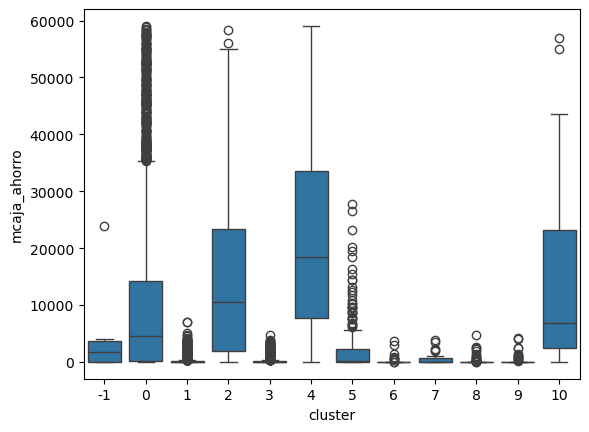

In [73]:
#3. mcaja_ahorro.
# Grafico.
lower_bound = df_analizar['mcaja_ahorro'].quantile(0.10)
upper_bound = df_analizar['mcaja_ahorro'].quantile(0.90)
filtered_data = df_analizar[(df_analizar['mcaja_ahorro'] >= lower_bound) & (df_analizar['mcaja_ahorro'] <= upper_bound)]
sns.boxplot(x='cluster', y='mcaja_ahorro', data=filtered_data)

<Axes: xlabel='cluster', ylabel='Visa_msaldopesos'>

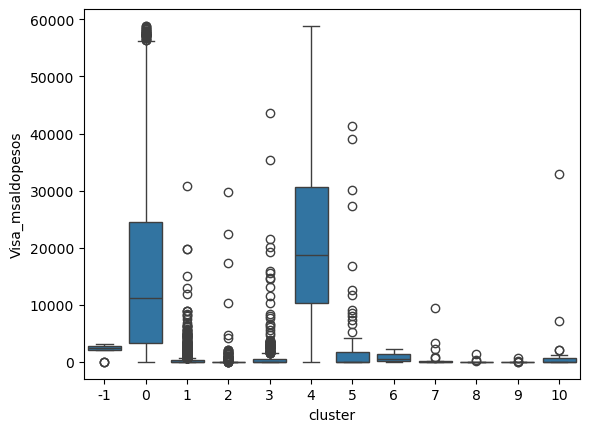

In [74]:
#4. Tarjetas de crédito # Hay un uso de la tarjeta de crédito
#Visa_msaldopesos
lower_bound = df_analizar['Visa_msaldopesos'].quantile(0.10)
upper_bound = df_analizar['Visa_msaldopesos'].quantile(0.90)

filtered_data = df_analizar[(df_analizar['Visa_msaldopesos'] >= lower_bound) & (df_analizar['Visa_msaldopesos'] <= upper_bound)]
sns.boxplot(x='cluster', y='Visa_msaldopesos', data=filtered_data)

<Axes: xlabel='cluster', ylabel='tc_pagadopesos_total'>

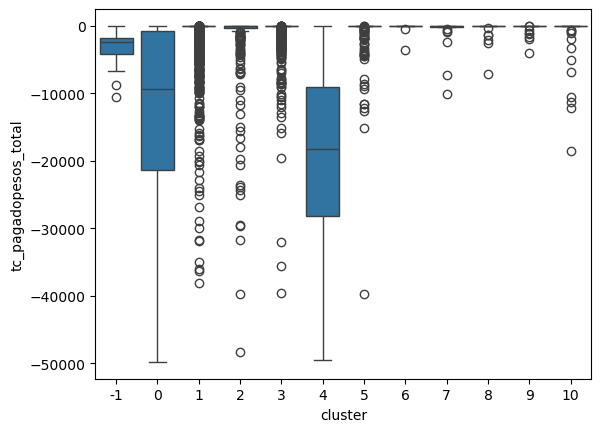

In [108]:
#tc_pagadopesos_total
lower_bound = df_analizar['tc_pagadopesos_total'].quantile(0.10)
upper_bound = df_analizar['tc_pagadopesos_total'].quantile(0.90)

filtered_data = df_analizar[(df_analizar['tc_pagadopesos_total'] >= lower_bound) & (df_analizar['tc_pagadopesos_total'] <= upper_bound)]
sns.boxplot(x='cluster', y='tc_pagadopesos_total', data=filtered_data)

<Axes: xlabel='cluster', ylabel='Visa_mpagominimo'>

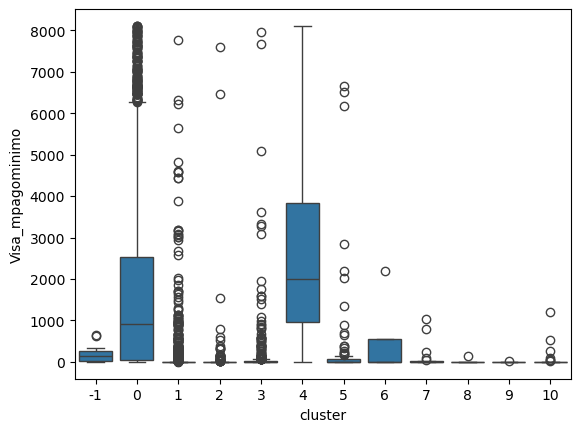

In [76]:
# Visa_mpagominimo
lower_bound = df_analizar['Visa_mpagominimo'].quantile(0.10)
upper_bound = df_analizar['Visa_mpagominimo'].quantile(0.90)

filtered_data = df_analizar[(df_analizar['Visa_mpagominimo'] >= lower_bound) & (df_analizar['Visa_mpagominimo'] <= upper_bound)]
sns.boxplot(x='cluster', y='Visa_mpagominimo', data=filtered_data)

In [86]:
# mpayroll_slope_3
cluster_0 = df_analizar.copy()
cluster_0["cluster"] = df_analizar['cluster'].apply(lambda x: '0' if x == 0 else 'Resto')

df_analizar.groupby("cluster")["mpayroll_slope_3"].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()

,cluster,mean,std,min,max,median
0,-1,-2770.977750,9598.948499,-33251.733,0.000,0.0000
1,0,-1796.529071,21603.706343,-395081.630,855861.505,0.0000
2,1,-549.856311,8125.757375,-330036.215,2756.550,0.0000
3,2,6482.579135,41848.986847,-131516.760,414372.810,2522.2990
4,3,NaN,NaN,NaN,NaN,NaN
5,4,10439.735983,228575.765087,-5353671.700,1869536.900,3572.9600
6,5,-2574.256093,20881.523138,-254966.511,5229.345,0.0000
7,6,30.431604,313.312537,0.000,3225.750,0.0000
8,7,739.774842,4523.895197,-10335.650,7369.370,1498.8570
9,8,-39.972365,259.317795,-1777.681,0.000,0.0000


In [104]:
# cumplimiento_limite.
df_analizar["cumplimiento_limite"] = df_analizar["Visa_mconsumospesos"]/df_analizar["Visa_mlimitecompra"]
cluster_0 = df_analizar.copy()
cluster_0["cluster"] = df_analizar['cluster'].apply(lambda x: '0' if x == 0 else 'Resto')

df_analizar.groupby("cluster")["cumplimiento_limite"].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()

,cluster,mean,std,min,max,median
0,-1,0.007022,0.006456,0.000000,0.020062,0.005335
1,0,0.072729,0.121349,-0.038785,1.208867,0.028290
2,1,0.004604,0.016015,-0.003812,0.338833,0.000711
3,2,0.004134,0.008885,-0.000076,0.048090,0.000000
4,3,0.006716,0.031709,-0.000662,0.432892,0.000857
5,4,0.084722,0.137444,-0.021025,1.197484,0.038932
6,5,0.022160,0.100842,-0.000195,0.766718,0.001964
7,6,0.000205,0.000355,0.000000,0.000615,0.000000
8,7,0.004790,0.008311,0.000000,0.024000,0.001244
9,8,0.001709,0.003088,0.000000,0.007639,0.000000


<Axes: xlabel='cluster', ylabel='mcuentas_saldo'>

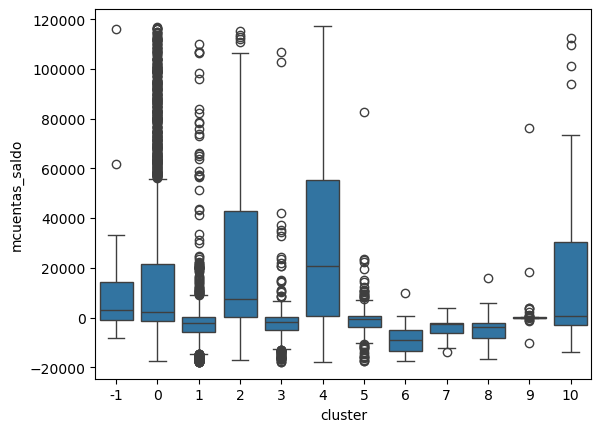

In [107]:
# mcuentas_saldo.
lower_bound = df_analizar['mcuentas_saldo'].quantile(0.10)
upper_bound = df_analizar['mcuentas_saldo'].quantile(0.90)

filtered_data = df_analizar[(df_analizar['mcuentas_saldo'] >= lower_bound) & (df_analizar['mcuentas_saldo'] <= upper_bound)]
sns.boxplot(x='cluster', y='mcuentas_saldo', data=filtered_data)

In [ ]:
# CONCLUSIÓN....
# No son trabajadores (payroll bajo) por ende, no tienen apego por el banco (menos comprometidos y más propensos a mover su dinero a otras instituciones con mejores ofertas).
# El banco saca mucho margen con la plata que tienen/invierten.
# Suele tener mayor $  en la caja de ahorro que la media (hasta el 75% tiene $25,583.28).
# Suelen gastar en TdeC (media -$28,864.39 ante un pago mínimo de $6,676.71)---> Si el banco no ofrece incentivos claros (puntos, descuentos, beneficios exclusivos), otros bancos con programas de tarjetas de crédito más atractivos podrían atraerlos fácilmente.

##### b. Clúster 1 vs clúster 3 (son parecidos).

In [121]:
descriptivo_cluster[1]

,mpasivos_margen,mcaja_ahorro,ctrx_quarter,m_promedio_caja_ahorro,mcaja_ahorro_slope_3,Visa_msaldopesos,proporcion_limite_visa_cubierto,tc_saldopesos_total,Visa_msaldototal,tc_pagadopesos_total,tc_consumo_total_slope_3,mprestamos_personales,mactivos_margen_slope_3,proporcion_financiacion_total_cubierto,mtarjeta_visa_consumo,cliente_edad,cliente_antiguedad
count,2768.000000,2768.000000,2768.000000,2768.000000,2759.000000,1714.000000,1714.000000,2768.000000,1714.000000,2768.000000,2759.000000,2768.000000,2759.000000,1840.000000,2768.000000,2768.000000,2768.00000
mean,10.617937,318.129906,11.197616,151.139434,-1050.269036,447.662970,0.002797,886.317937,340.597235,-871.452287,-439.890414,396.062157,39.483181,0.007595,175.931871,47.379697,101.20159
std,123.994379,761.491020,15.820562,356.167800,7590.175777,2376.771384,0.030893,12231.120198,2109.177183,4603.794017,2793.016092,2029.412882,603.816153,0.074572,581.177384,14.160267,77.43077
min,-4938.720000,0.000000,0.000000,0.000000,-200507.270000,-11606.810000,-0.085251,-13104.660000,-34039.590000,-139587.000000,-69783.830000,0.000000,-15564.169000,-0.092932,0.000000,19.000000,2.00000
25%,0.000000,0.000000,0.000000,0.000000,-84.049000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011000,0.000000,0.000000,36.000000,42.00000
50%,2.165000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.084000,0.000000,0.000000,45.000000,75.00000
75%,19.812500,104.325000,16.000000,51.140000,0.000000,129.100000,0.000467,0.000000,108.762500,0.000000,0.000000,0.000000,56.894500,0.000707,0.000000,58.000000,148.00000
max,401.120000,6956.170000,170.000000,2517.585000,4606.210000,70680.470000,0.856155,594085.560000,60256.160000,4474.130000,16650.000000,20122.690000,7899.316000,2.038777,6564.090000,94.000000,376.00000


In [122]:
#1. ctrx_quarter ----> No reciben un sueldo (no apego con el banco).
# Gráfico.
cluster_1 = df_analizar.copy()
cluster_1["cluster"] = df_analizar['cluster'].apply(lambda x: '1' if x == 1 else 'Resto')

df_analizar.groupby("cluster")[["ctrx_quarter"]].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()

cluster ctrx_quarter                            
                   mean        std min   max median
0       -1    44.000000  41.236653   0   140   29.5
1        0    71.952932  83.286603   0  1356   50.0
2        1    11.197616  15.820562   0   170    6.0
3        2    77.059211  50.320390   3   254   65.5
4        3    10.989218  14.877544   0   108    6.0
5        4   138.158954  67.813714  15   407  130.0
6        5    26.455696  36.232464   0   234   15.0
7        6    10.715517  16.234052   0    94    4.0
8        7    15.148148  11.336475   0    44   13.0
9        8     8.083333  11.937630   0    61    4.0
10       9     9.333333  14.566759   0    69    3.0
11      10    46.185185  40.166199   3   215   38.0

In [24]:
# Casi sin uso de la caja de ahorro (de hecho, va descendiendo).
# Casi sin uso de la tarjeta de crédito VISA (de hecho, casi sin saldo, sin consumos, casi todo el limite descubierto).
# No genera pasivos (no usa los productos financieros/deposita plata).
# Casi sin movimientos (ctrx_quarter).
# Sin prestamos tomados.
# La antiguedad es menor que el clúster 0 y 4.
# 47 años
# 101 meses como cliente.

In [123]:
descriptivo_cluster[3]

,mpasivos_margen,mcaja_ahorro,m_promedio_caja_ahorro,tc_consumo_total,mpagodeservicios_slope_3,mcuentas_saldo,ctrx_quarter,tc_saldototal_total,ctrx_quarter_slope_3,tc_saldopesos_total,tc_fechaalta_mayor,mprestamos_personales,m_promedio_prestamos_personales,tc_pagadopesos_total,mtarjeta_visa_consumo,cliente_edad,cliente_antiguedad
count,742.000000,742.000000,742.000000,742.000000,0.0,7.420000e+02,742.000000,742.000000,0.0,742.000000,514.000000,742.000000,30.000000,742.000000,742.000000,742.000000,742.00000
mean,17.569879,294.226402,141.508103,364.375822,NaN,-6.639171e+03,10.989218,1763.137547,NaN,1948.042156,2627.634241,348.378949,4879.142917,-860.931725,253.607332,48.463612,110.14690
std,67.333964,700.274394,333.681841,1013.673706,NaN,1.880529e+05,14.877544,15511.211789,NaN,16822.752442,1958.173500,1953.288325,2002.870842,3066.217019,708.898117,14.081530,82.48727
min,-921.950000,0.000000,0.000000,0.000000,NaN,-2.065768e+06,0.000000,-12573.800000,NaN,-12652.130000,213.000000,0.000000,1507.395000,-39578.160000,0.000000,23.000000,10.00000
25%,0.000000,0.000000,0.000000,0.000000,NaN,-8.655650e+03,0.000000,0.000000,NaN,0.000000,1146.750000,0.000000,3598.410000,0.000000,0.000000,37.000000,44.25000
50%,1.780000,0.000000,0.000000,0.000000,NaN,-2.192080e+03,6.000000,0.000000,NaN,0.000000,1892.000000,0.000000,4882.655000,0.000000,0.000000,47.000000,79.00000
75%,19.977500,122.652500,61.326250,0.000000,NaN,1.134000e+01,15.000000,2.175000,NaN,2.467500,3953.250000,0.000000,6140.637500,0.000000,0.000000,59.000000,163.00000
max,439.920000,4748.240000,1892.175000,8297.550000,NaN,4.111132e+06,108.000000,331044.000000,NaN,356362.540000,9194.000000,23811.850000,8554.700000,0.000000,4198.940000,91.000000,373.00000


In [26]:
# Parece no tener pasivos (falta de productos financieros).
# No usa la caja de ahorro ni las tarjetas de crédito.
# Casi sin saldo en la cuenta.
# Casi no hace transacciones bancarias.



# ------------> Muy parecido al clúster 1... BUSCAR LA DIFERENCIA... en otras variables? hacer otro árbol?
# --------------> RECOMENDACION: PERDERLOS.

##### c. Clúster 5.

In [127]:
descriptivo_cluster[5]

,mprestamos_personales,m_promedio_prestamos_personales,cprestamos_personales,m_promedio_prestamos_personales_slope_3,mprestamos_personales_slope_3,cprestamos_personales_slope_3,ctrx_quarter,mactivos_margen,m_promedio_caja_ahorro,cpayroll_trx,mrentabilidad_annual,mcuentas_saldo,mpayroll,mcaja_ahorro,m_promedio_comisiones_otras,cliente_edad,cliente_antiguedad
count,2.370000e+02,237.000000,237.000000,182.000000,183.000000,183.000000,237.000000,237.000000,237.000000,237.000000,237.000000,2.370000e+02,237.000000,237.000000,192.000000,237.000000,237.000000
mean,1.497483e+05,61332.592733,9.177215,-197.084040,767.180448,0.257923,26.455696,1344.222996,1122.640219,0.016878,29332.131266,-2.606851e+04,115.895316,2373.172996,471.867686,49.215190,96.755274
std,1.617756e+05,99985.139812,22.568592,14560.879692,20989.500367,4.711015,36.232464,4909.603674,2266.596363,0.158549,38887.738763,1.175524e+05,1039.770982,4720.245647,433.311235,13.864359,73.535585
min,1.626112e+04,245.379000,1.000000,-33543.271333,-46140.750000,-57.000000,0.000000,-21576.360000,0.000000,0.000000,-66374.350000,-1.036971e+06,0.000000,0.000000,-248.767500,21.000000,2.000000
25%,3.729191e+04,10688.770000,1.000000,-3575.459750,-4813.157500,0.000000,5.000000,25.880000,0.000000,0.000000,10606.890000,-1.003275e+04,0.000000,0.000000,180.780625,39.000000,41.000000
50%,8.013810e+04,25720.670000,3.000000,-1354.845000,-2033.955000,0.000000,15.000000,359.880000,67.900000,0.000000,22669.310000,-2.005440e+03,0.000000,135.800000,399.103750,47.000000,70.000000
75%,2.007750e+05,69810.270000,8.000000,-392.177720,1197.890000,0.500000,29.000000,1358.190000,1119.885000,0.000000,38152.750000,1.424400e+02,0.000000,2306.960000,728.230000,60.000000,134.000000
max,1.078397e+06,721003.790000,270.000000,119068.382455,210044.545000,21.500000,234.000000,30354.310000,13848.715000,2.000000,273018.170000,8.251845e+04,10458.690000,27697.430000,3766.000000,82.000000,323.000000


<Axes: xlabel='cluster', ylabel='mprestamos_personales'>

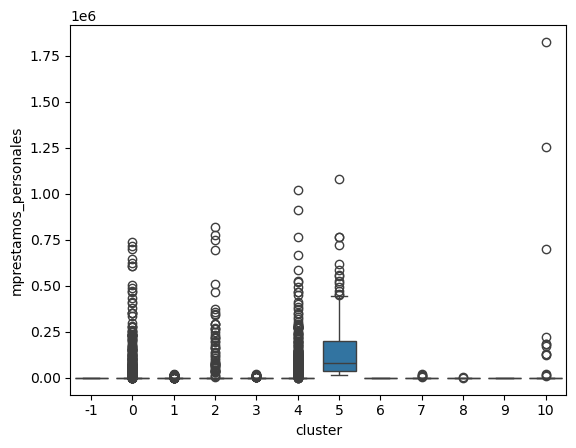

In [128]:
# mprestamos_personales.
#lower_bound = df_analizar['mprestamos_personales'].quantile(0.10)
#upper_bound = df_analizar['mprestamos_personales'].quantile(0.90)

#filtered_data = df_analizar[(df_analizar['mprestamos_personales'] >= lower_bound) & (df_analizar['mprestamos_personales'] <= upper_bound)]
sns.boxplot(x='cluster', y='mprestamos_personales', data=df_analizar)

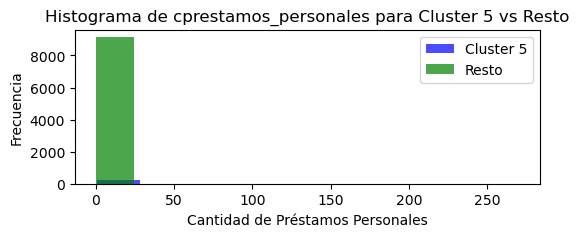

In [137]:
# cprestamos_personales.
cluster_5 = df_analizar.copy()
cluster_5['cluster'] = df_analizar['cluster'].apply(lambda x: '5' if x == 5 else 'resto')

# Grafico.
plt.figure(figsize=(6,2))

plt.hist(cluster_5[cluster_5['cluster'] == '5']['cprestamos_personales'], bins=10, alpha=0.7, label='Cluster 5', color='blue')
plt.hist(cluster_5[cluster_5['cluster'] == 'resto']['cprestamos_personales'], bins=10, alpha=0.7, label='Resto', color='green')

# Título y labels.
plt.xlabel('Cantidad de Préstamos Personales')
plt.ylabel('Frecuencia')
plt.title('Histograma de cprestamos_personales para Cluster 5 vs Resto')
plt.legend()

# Show.
plt.show()

In [29]:
# Uso de prestamos personales (con pendiente positiva).
# Margen por Activos positivo.
# No suele tener mucha plata en la caja de ahorros.
# No son trabajadores.
# Posible competencia vs otros bancos ante tasas más favorables?

##### d. Clúster 6.

In [141]:
descriptivo_cluster[6]

,mactivos_margen,mrentabilidad,mrentabilidad_annual,mrentabilidad_annual_slope_3,mpasivos_margen,mactivos_margen_slope_3,mrentabilidad_slope_3,mcuentas_saldo,mpasivos_margen_slope_3,mcuenta_corriente,mcuenta_corriente_slope_3,m_promedio_comisiones_otras,cliente_antiguedad,mcomisiones,mcaja_ahorro,cliente_edad,cliente_antiguedad
count,116.000000,116.000000,116.000000,106.000000,116.000000,106.000000,106.000000,1.160000e+02,106.000000,1.160000e+02,106.000000,94.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,11966.981207,15639.613276,101452.974052,10512.422425,98.783017,2089.512311,2250.082519,-7.642149e+04,-33.019085,-6.438865e+04,-7444.719774,567.863637,112.327586,1486.472328,94.225345,47.905172,112.327586
std,8669.445639,10297.027971,82140.849469,9996.687321,105.902604,3433.462292,4321.874491,1.590348e+05,144.310195,1.421081e+05,16230.730572,384.924351,84.774666,1180.454202,462.584059,13.932120,84.774666
min,2850.820000,6335.680000,-5964.880000,-26050.360000,-265.390000,-11611.710000,-15069.590000,-1.201256e+06,-1235.340000,-1.105003e+06,-98483.040000,-179.201000,14.000000,-1792.010000,0.000000,23.000000,14.000000
25%,6312.032500,8891.115000,51996.587500,5606.243750,40.655000,347.122000,486.206000,-5.487955e+04,-23.447750,-4.825076e+04,-5876.923500,307.923750,44.750000,62.915000,0.000000,38.000000,44.750000
50%,8925.500000,11589.955000,74654.935000,7642.242500,66.650000,1114.141000,1388.297000,-2.441122e+04,4.469000,-2.177538e+04,-2891.135000,546.956667,91.500000,1613.785000,0.000000,45.000000,91.500000
75%,14216.567500,19432.670000,133196.380000,11756.485250,131.302500,2981.142500,3027.495000,-1.030798e+04,13.083250,-9.339595e+03,-525.496000,796.100000,145.000000,2285.117500,0.000000,59.250000,145.000000
max,44761.700000,55656.890000,499393.550000,50316.340000,360.540000,18611.060000,22163.115000,9.850340e+03,90.950000,0.000000e+00,14014.759000,1531.730000,376.000000,5743.400000,3608.250000,81.000000,376.000000


<Axes: xlabel='cluster', ylabel='mactivos_margen'>

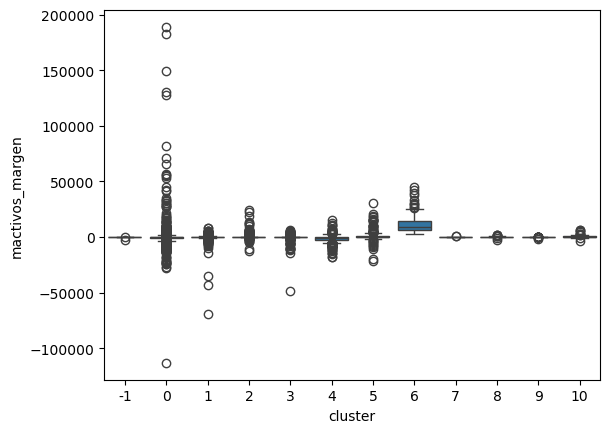

In [139]:
# mactivos_margen.
#lower_bound = df_analizar['mactivos_margen'].quantile(0.10)
#upper_bound = df_analizar['mactivos_margen'].quantile(0.90)

#filtered_data = df_analizar[(df_analizar['mactivos_margen'] >= lower_bound) & (df_analizar['mactivos_margen'] <= upper_bound)]
sns.boxplot(x='cluster', y='mactivos_margen', data=df_analizar)

<Axes: xlabel='cluster', ylabel='mrentabilidad'>

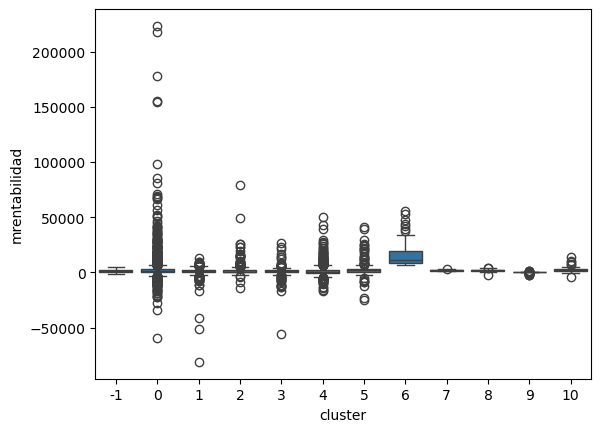

In [150]:
# mrentabilidad.
#lower_bound = df_analizar['mactivos_margen'].quantile(0.10)
#upper_bound = df_analizar['mactivos_margen'].quantile(0.90)

#filtered_data = df_analizar[(df_analizar['mactivos_margen'] >= lower_bound) & (df_analizar['mactivos_margen'] <= upper_bound)]
sns.boxplot(x='cluster', y='mrentabilidad', data=df_analizar)

In [31]:
# Perfiles muy importantes (resaltarlos) ya que son muy rentables para el banco y manejan grandes volúmenes de activos.
# De hecho, dicha rentabilidad, está en aumento (gran consumo de productos financieros).
# Lo mismos con el margen por activos (cobro intereses).
# Ahora bien, tienen saldo en cuenta negativo, cuenta corriendo negativo,  y los pasivos_margen están cayendo.
# La presencia de saldos negativos y la variabilidad en mcuentas_saldo y mcuenta_corriente sugiere que los clientes en el Cluster 6 realizan transacciones de gran volumen, lo que podría ser diferente a la frecuencia alta pero de menor magnitud observada en Cluster 5.

##### e. Clúster 7.

In [142]:
descriptivo_cluster[7]

,mpayroll,m_payroll_total,m_promedio_comisiones_otras,mpasivos_margen,m_promedio_comisiones_mantenimiento,mcaja_ahorro,ctrx_quarter,m_payroll2_total,m_promedio_caja_ahorro,mcomisiones,mcomisiones_mantenimiento,cpayroll_trx,mpayroll_slope_3,numero_de_cliente,mcuentas_saldo,cliente_edad,cliente_antiguedad
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,19.000000,2.700000e+01,27.000000,27.000000,27.000000
mean,5808.040741,5808.040741,639.552225,16.693704,1743.877222,626.555185,15.148148,1.592593,299.879537,1607.180741,1794.430741,1.592593,739.774842,9.671756e+08,631.899259,53.740741,89.185185
std,3632.154899,3632.154899,357.065656,39.755214,473.804000,1109.637964,11.336475,0.693889,554.832195,470.070973,503.693083,0.693889,4523.895197,3.635144e+08,24447.352798,15.338721,88.437304
min,3.420000,3.420000,109.912000,0.000000,1364.940000,0.000000,0.000000,1.000000,0.000000,1028.610000,1364.940000,1.000000,-10335.650000,2.492463e+08,-13684.280000,29.000000,9.000000
25%,3184.695000,3184.695000,355.150000,0.015000,1364.940000,0.000000,8.500000,1.000000,0.000000,1225.040000,1364.940000,1.000000,9.745000,7.404642e+08,-6294.175000,40.000000,36.000000
50%,5865.000000,5865.000000,612.520000,2.630000,1774.040000,21.300000,13.000000,2.000000,10.650000,1592.200000,1774.040000,2.000000,1498.857000,8.911258e+08,-2489.270000,59.000000,50.000000
75%,7889.785000,7889.785000,796.100000,17.560000,1774.040000,723.495000,22.500000,2.000000,202.208750,1745.150000,1851.105000,2.000000,3049.800000,1.311733e+09,-1868.355000,67.500000,142.000000
max,11730.000000,11730.000000,1531.730000,203.340000,3413.330000,3891.160000,44.000000,4.000000,1945.580000,3063.460000,3413.330000,4.000000,7369.370000,1.531819e+09,121099.560000,78.000000,374.000000


In [34]:
# Tienen payroll, pero bajo.
# Se les cobra muchas comisiones de mantenimiento y otras.
# No tienen mucha plata en la caja de ahorro.
# No mucho margen por pasivos.
# Realizan algunas transacciones.
# Cuentas saldo en positivo.
# Son más bien gente de alta edad y con mucha antigüedad.

# -------------> Comparación con el clúster 4.
# Los clientes del Cluster 4 tienen ingresos más altos y, por ende, mayor variedad de productos financieros con mejores condiciones?????. 
# A estos se les puede ofrecer cuentas premium o productos de inversión personalizados ??????

##### f. Clúster 8 vs. Clúster 9 (son parecidos).

In [143]:
descriptivo_cluster[8]

,tc_fechaalta_mayor,Visa_fechaalta,mcuentas_saldo,tc_fechalta_menor,Master_fechaalta,m_promedio_comisiones_otras,mactivos_margen,Master_Fvencimiento,mcuenta_corriente,cliente_antiguedad,Visa_Fvencimiento,mcomisiones_mantenimiento,antiguedad_tarjetas,m_promedio_comisiones_mantenimiento,cliente_antiguedad_6,cliente_edad,cliente_antiguedad
count,108.000000,105.000000,108.000000,108.000000,107.000000,97.000000,108.000000,107.000000,108.000000,108.000000,105.000000,108.000000,108.0,91.000000,108.000000,108.000000,108.000000
mean,303.000000,301.523810,-12583.604722,302.351852,305.242991,730.920888,241.897130,-1571.411215,-11511.852685,17.750000,-1905.514286,1611.056019,1.0,1907.501648,1.231481,42.351852,17.750000
std,60.333807,60.763428,15546.740962,60.164310,55.910954,328.277459,467.970653,141.322924,15630.052121,19.623143,58.619391,872.059988,0.0,578.018677,0.780684,14.207616,19.623143
min,31.000000,31.000000,-72633.550000,31.000000,31.000000,4.220000,-2577.360000,-2160.000000,-79410.090000,2.000000,-2160.000000,0.000000,1.0,411.400000,1.000000,22.000000,2.000000
25%,269.250000,267.000000,-16344.940000,269.250000,270.500000,612.520000,16.885000,-1581.000000,-14575.440000,10.000000,-1947.000000,1364.940000,1.0,1622.810000,1.000000,32.000000,10.000000
50%,311.500000,306.000000,-5968.850000,310.500000,312.000000,796.100000,112.405000,-1521.000000,-4490.460000,12.000000,-1886.000000,1774.040000,1.0,1774.040000,1.000000,39.000000,12.000000
75%,347.250000,347.000000,-2641.837500,347.000000,347.500000,796.100000,391.037500,-1491.000000,-891.135000,13.000000,-1856.000000,1928.170000,1.0,1928.170000,1.000000,50.250000,13.000000
max,392.000000,392.000000,15823.410000,392.000000,392.000000,1531.730000,1845.670000,-1460.000000,0.000000,129.000000,-1825.000000,3413.330000,1.0,3413.330000,6.000000,81.000000,129.000000


In [36]:
# Son clientes con TC de hace muy poco tiempo (Usan ambas tarjetas, tanto Visa como Mastercard nuevos) ----> Analizar deudas por la TC.
# Con saldo total en todas las cuentas negativo (especialmente, en la cuenta corriente) ---> Analizar préstamos, sobregiros. Se puede deber a problemas financieros o simplemente de un uso intensivo de las cuentas corrientes.
# Tienen mactivos_margen (intereses), lo cual habla de cobro de intereses.
# Les cobran "comisiones otras" (por descubierto?) y "comisiones de mantenimiento"
# mactivos_margen positivo, ya que deben plata al banco por los descubiertos.
# Tienen una antiguedad en el banco muy chica (18 meses).
# 42 años.

# Estos intereses/comisiones se puede deber para el mantenimiento de sus servicios, debido que son clientes nuevos. (servicios ---> Tarjeta de Crédito, Uso de descubierto).
# Porque no usan la tarjeta?

# -----------> Solución: Bajar los intereses/comisiones por saldos negativos? O son clientes que se fueron haciendo morosos?

In [37]:
# cambio de trabajo? comisiones muy altas? consiguio banco con mejores condiciones?

In [144]:
descriptivo_cluster[9]

,cliente_antiguedad,tc_fechaalta_mayor,Visa_fechaalta,Master_fechaalta,mpasivos_margen,mrentabilidad,tc_fechalta_menor,Visa_Fvencimiento,mrentabilidad_annual,tcuentas,m_promedio_caja_ahorro,numero_de_cliente,antiguedad_tarjetas,mcomisiones_otras,tc_fvencimiento_mayor,cliente_edad,cliente_antiguedad
count,57.000000,57.000000,57.000000,56.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,5.700000e+01,57.0,57.000000,57.000000,57.000000,57.000000
mean,18.947368,148.017544,148.017544,143.535714,-72.304035,-125.544386,141.122807,-2057.175439,1409.448596,1.385965,156.654035,1.098998e+09,1.0,-14.298772,-1929.105263,41.017544,18.947368
std,42.399217,125.295863,125.295863,118.399472,346.934318,755.310391,118.743281,122.403478,5696.118090,0.491150,383.266911,3.720065e+08,0.0,613.156956,281.298500,12.586119,42.399217
min,1.000000,1.000000,1.000000,1.000000,-1661.530000,-2705.520000,1.000000,-2190.000000,-6770.610000,1.000000,0.000000,2.592021e+08,1.0,-2485.240000,-2190.000000,23.000000,1.000000
25%,2.000000,23.000000,23.000000,23.750000,0.000000,0.000000,23.000000,-2190.000000,0.000000,1.000000,0.000000,7.374367e+08,1.0,0.000000,-2190.000000,32.000000,2.000000
50%,6.000000,137.000000,137.000000,135.000000,0.000000,0.000000,133.000000,-2067.000000,45.920000,1.000000,0.000000,1.144087e+09,1.0,0.000000,-2067.000000,37.000000,6.000000
75%,13.000000,217.000000,217.000000,216.250000,1.750000,20.560000,216.000000,-1975.000000,976.490000,2.000000,14.490000,1.450942e+09,1.0,0.340000,-1610.000000,46.000000,13.000000
max,266.000000,455.000000,455.000000,377.000000,208.890000,1655.850000,377.000000,-1794.000000,36237.980000,2.000000,1970.920000,1.591771e+09,1.0,1592.200000,-1460.000000,73.000000,266.000000


In [39]:
# También son clientes nuevos (como el clúster 8).
# Tienen tarjeta VISA y MASTERCARD hace poco tiempo.
# Generan una rentabilidad negativa al banco! (cluster 8 aunque sea genera comisiones) pero rentabilidad anual.
# Suelen tener al menos una caja de ahorro y una cuenta corriente.
# mpasivos_margen en negativo :O
# Posee algo de plata en la caja de ahorro.
# mcomisiones_otras en negativo.

# ----------------> Ahondar en la diferencia con el clúster 8.

In [ ]:
#Perfil de los clientes en riesgo de abandono
#Clúster 8:
#Perfil: Clientes con una relación moderada con el banco, usando diversos productos financieros (como cuentas y tarjetas), pero con una situación financiera comprometida (saldos negativos y deudas). Están pagando comisiones relativamente altas y pueden estar buscando mejores opciones en otros bancos.
#Clúster 9:
#Perfil: Clientes recientes, que han abierto productos financieros hace poco tiempo, con una actividad y rentabilidad baja. Estos clientes aún no han consolidado una relación fuerte con el banco, y si no ven mejoras o beneficios claros, podrían decidir abandonar rápidamente.

##### g. Clúster 10.

In [145]:
descriptivo_cluster[10]

,ccomisiones_mantenimiento,m_payroll_total,mcomisiones_mantenimiento,m_promedio_comisiones_mantenimiento,mpayroll,mcomisiones,m_promedio_comisiones_mantenimiento_slope_3,ccaja_ahorro,mcomisiones_otras,m_payroll2_total,m_promedio_comisiones_otras,mcomisiones_mantenimiento_slope_3,cpayroll_trx,mpayroll_slope_3,ccomisiones_mantenimiento_slope_3,cliente_edad,cliente_antiguedad
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,38.000000,54.000000,54.000000,54.000000,51.000000,44.000000,54.000000,44.000000,44.000000,54.000000,54.000000
mean,1.092593,83883.386481,1495.600926,1526.520556,83774.775370,1637.860000,-22.507560,3.240741,1637.860000,1.888889,337.079676,341.456659,1.870370,18478.254409,0.265909,46.611111,94.351852
std,0.351198,105585.294796,1101.044180,909.701746,105565.580488,2006.629735,676.634716,1.164493,2006.629735,1.021775,502.436266,657.312858,1.010255,55645.733049,0.369124,14.278122,73.008957
min,1.000000,11964.600000,-4434.120000,-2217.060000,11964.600000,-3979.620000,-2072.615000,2.000000,-3979.620000,1.000000,-1989.810000,-1928.170000,1.000000,-32701.640000,-0.500000,23.000000,9.000000
25%,1.000000,24339.750000,1364.940000,1364.940000,24339.750000,1225.040000,0.000000,2.000000,1225.040000,1.000000,177.786985,0.000000,1.000000,-1214.430000,0.000000,34.500000,35.000000
50%,1.000000,51546.835000,1774.040000,1774.040000,51546.835000,1667.335000,81.820000,4.000000,1667.335000,2.000000,296.590000,204.550000,2.000000,3782.632500,0.000000,43.000000,83.000000
75%,1.000000,97999.765000,1928.170000,1928.170000,97999.765000,2257.172500,224.471500,4.000000,2257.172500,3.000000,472.993750,809.563000,3.000000,14517.600000,0.500000,58.000000,138.250000
max,3.000000,663336.190000,2626.150000,2626.150000,663336.190000,13361.870000,1252.975000,6.000000,13361.870000,5.000000,2226.978333,1928.170000,5.000000,331668.095000,1.000000,85.000000,288.000000


In [ ]:
# Cobra un salario.
# Mucha cantidad de mantenimientos, y por ende, monto (en aumento el monto).
# Muchas comisiones en general
# Tiene muchas cajas de ahorro.
# Se le cobran muchas comisiones_otras.

#### 3. Análisis multivariado.

In [84]:
# Mantener solo las 10 primeras variables más importantes por cluster
top_10_features_per_cluster = set()

for cluster, features in important_features_by_cluster.items():
    top_10_features_per_cluster.update(features[:10])

# Convertimos el set en una lista.
top_10_features_list = list(top_10_features_per_cluster)

In [ ]:
# Función para eliminar outliers basada en IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Crear boxplots sin outliers para cada una de las variables seleccionadas
for feature in top_10_features_list:
    df_filtered = remove_outliers(df_analizar, feature)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="cluster", y=feature, data=df_filtered)
    plt.title(f"Boxplot de {feature} aperturado por Cluster (sin outliers).")
    plt.show()

In [152]:
df_analizar.groupby("cluster")[["mrentabilidad"]].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()

cluster mrentabilidad                                              
                    mean           std       min        max     median
0       -1   1505.917143   1843.426381  -1341.16    5105.28   1217.000
1        0   2284.540506   9008.484524 -59934.89  223462.70   1443.410
2        1   1473.602240   2630.321498 -81181.41   12748.26   1648.600
3        2   2477.889243   6736.358608 -13830.98   79572.49    653.690
4        3    967.272951   3425.879544 -56288.24   26520.97   1274.280
5        4   1356.909215   4837.782717 -16781.95   50479.33    712.565
6        5   3040.096160   6719.261404 -25309.07   41095.39   2015.780
7        6  15639.613276  10297.027971   6335.68   55656.89  11589.955
8        7   1783.582593    540.355134   1105.11    3404.52   1741.910
9        8   1776.904907    872.384160  -2180.81    3757.17   1719.335
10       9   -125.544386    755.310391  -2705.52    1655.85      0.000
11      10   2741.542593   2832.069564  -3777.83   13545.34   2183.350